<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#4)-Preprocessing" data-toc-modified-id="4)-Preprocessing-1">4) Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-1.1">Feature Selection</a></span></li><li><span><a href="#Scaling-and-one-hot-encoding-the-data" data-toc-modified-id="Scaling-and-one-hot-encoding-the-data-1.2">Scaling and one-hot encoding the data</a></span></li><li><span><a href="#Splitting-and-resampling" data-toc-modified-id="Splitting-and-resampling-1.3">Splitting and resampling</a></span></li></ul></li></ul></div>

## 4) Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [2]:
pirate_data = pd.read_csv(f"data/pirate_data_visualized.csv", index_col = 0)
pirate_data['DATE (LT)'] = pd.to_datetime(pirate_data['DATE (LT)'])
pirate_data.head()

,DATE (LT),REGION,COUNTRY,INCIDENT TYPE,VESSEL TYPE,MAERSK?,VESSEL ACTIVITY LOCATION,LAT,LONG,TIME OF DAY,...,MONTH,WEEK,DAY,WEEKDAY,YEAR_MONTH,X,Y,datestring,color,REGION_NR
703,2015-01-04,East Africa,Djibouti,Suspicious activity at sea,Merchant vessel,0,Off shore,12.553333,43.426667,Unknown,...,1,1,4,6,2015-01,4.834234e+06,1.408747e+06,2015-01-04,#1f78b4,1
702,2015-01-04,South East Asia,Singapore,Theft at sea,Tug,0,Off shore,1.324500,104.541500,Morning,...,1,1,4,6,2015-01,1.163751e+07,1.474558e+05,2015-01-04,#fdbf6f,6
701,2015-01-04,North Africa,Libya,Other maritime risk,Crude oil tanker,0,Anchorage,32.780116,22.663078,Afternoon,...,1,1,4,6,2015-01,2.522842e+06,3.866154e+06,2015-01-04,#fdbf6f,3
700,2015-01-06,East Africa,Djibouti,Suspicious activity at sea,Merchant vessel,0,Off shore,13.253333,42.956667,Afternoon,...,1,2,6,1,2015-01,4.781914e+06,1.488690e+06,2015-01-06,#1f78b4,1
699,2015-01-07,West Africa,Nigeria,Kidnap/ransom at anchorage,Unknown vessel type,0,Anchorage,4.638297,6.812897,Unknown,...,1,2,7,2,2015-01,7.584082e+05,5.168978e+05,2015-01-07,#fdbf6f,7


### Feature Selection

In [3]:
# The variable "Incident Type" would cause data leakage. Others are too granular or were created for visualization.
modelling_df = pirate_data.drop(columns=["DATE (LT)", "INCIDENT TYPE", "COUNTRY", "ATTACKS", "YEAR_MONTH", "X", 
                                         "Y", "datestring", "color", "REGION_NR"])

modelling_df["WEEK"] = modelling_df["WEEK"].astype(int)
modelling_df.dtypes

REGION                       object
VESSEL TYPE                  object
MAERSK?                       int64
VESSEL ACTIVITY LOCATION     object
LAT                         float64
LONG                        float64
TIME OF DAY                  object
ATTACK SUCCESS                int64
YEAR                          int64
MONTH                         int64
WEEK                          int64
DAY                           int64
WEEKDAY                       int64
dtype: object

### Scaling and one-hot encoding the data

In [4]:
from sklearn.preprocessing import minmax_scale
modelling_df["LAT"] = minmax_scale(X=modelling_df["LAT"])
modelling_df["LONG"] = minmax_scale(X=modelling_df["LONG"])

OHE = pd.get_dummies(modelling_df[["REGION", "VESSEL TYPE", "VESSEL ACTIVITY LOCATION", 
                                       "TIME OF DAY", "YEAR", "MONTH", "WEEK", "DAY", "WEEKDAY"]])

modelling_df_merged = pd.concat([modelling_df, OHE], axis = 1, sort = False)


In [5]:
modelling_df_merged = modelling_df_merged.drop(columns = ["REGION", "VESSEL TYPE", 
                                                          "VESSEL ACTIVITY LOCATION", "TIME OF DAY", "YEAR", 
                                                          "MONTH", "WEEK", "DAY", "WEEKDAY"])
modelling_df_merged.head()

,MAERSK?,LAT,LONG,ATTACK SUCCESS,REGION_Americas,REGION_East Africa,REGION_Eastern Mediterranean,REGION_North Africa,REGION_North East Asia,REGION_South Asia,...,VESSEL TYPE_Unknown vessel type,VESSEL ACTIVITY LOCATION_Anchorage,VESSEL ACTIVITY LOCATION_Berth,VESSEL ACTIVITY LOCATION_Off shore,VESSEL ACTIVITY LOCATION_Unknown,TIME OF DAY_Afternoon,TIME OF DAY_Evening,TIME OF DAY_Morning,TIME OF DAY_Night,TIME OF DAY_Unknown
703,0,0.552486,0.553560,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
702,0,0.350650,0.807465,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
701,0,0.916060,0.467296,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
700,0,0.565069,0.551607,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
699,0,0.410215,0.401445,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1


Now that all the variables are numeric, we can easily check for correlations between them.

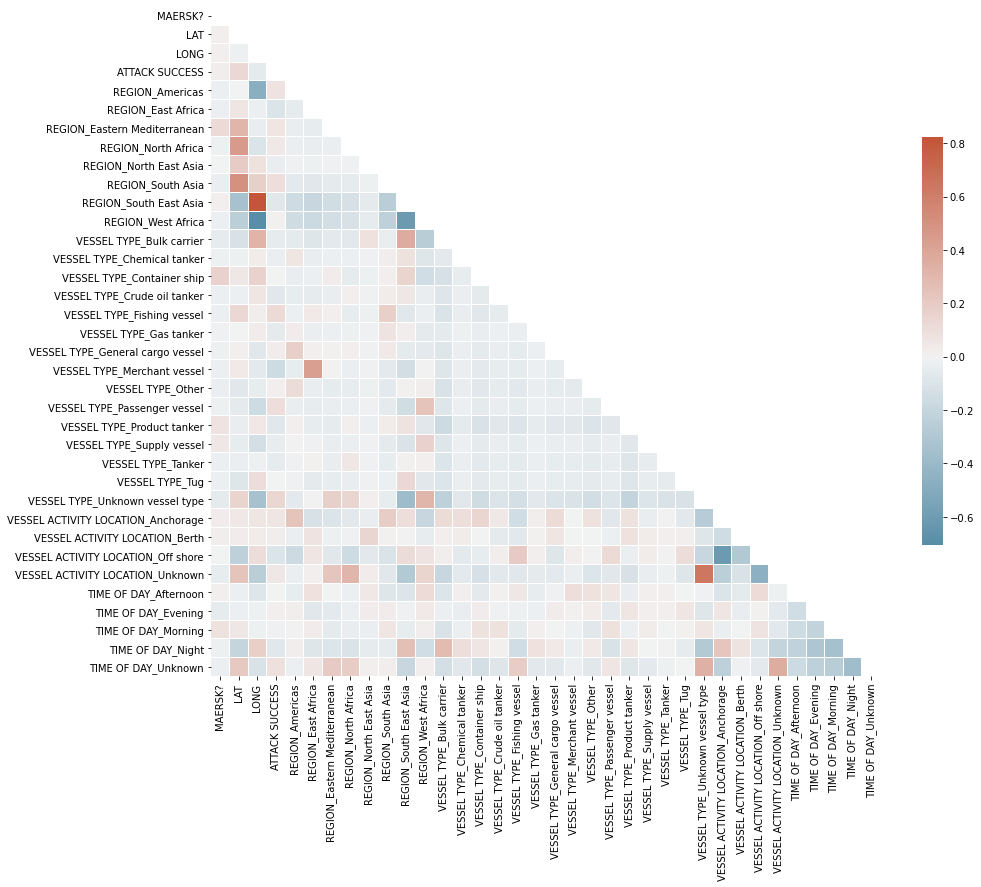

In [6]:
variables = modelling_df_merged

corr = round(variables.corr(),3)
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap= cmap, center=0,
            square=True, linewidths=.05, cbar_kws={"shrink": .5});


Some of the regions are correlated with the longitude, but that was to be expected. Also, it makes sense that an unknown vessel type is correlated with an unknown vessel location of the attack. Missing information appears to affect several variables of the same rows at once.

### Splitting and resampling

In [8]:
# Add the date back in for the train/test split.
modelling_df_merged_date = pd.concat([modelling_df_merged, pirate_data["DATE (LT)"]], axis = 1, sort = False)

In [9]:
# Split into independent and dependent variables. 
X = modelling_df_merged_date.loc[:, modelling_df_merged_date.columns != 'ATTACK SUCCESS']
y = modelling_df_merged_date[["DATE (LT)", "ATTACK SUCCESS"]]

# Then assign data from the last three months to the test set. The rest is training data.
X_train = X[X["DATE (LT)"] < "2016-04-01"]
X_test = X[X["DATE (LT)"] >= "2016-04-01"]
y_train = y[y["DATE (LT)"] < "2016-04-01"]
y_test =  y[y["DATE (LT)"] >= "2016-04-01"]

X_train.shape, X_test.shape

((642, 36), (143, 36))

In [10]:
# Drop the date column again.
X_train = X_train.drop(columns = "DATE (LT)")
X_test = X_test.drop(columns = "DATE (LT)")
y_train = y_train.drop(columns = "DATE (LT)")
y_test = y_test.drop(columns = "DATE (LT)")

In [11]:
y_train.value_counts(), y_test.value_counts()
# The data set is unbalanced.

(ATTACK SUCCESS
 1                 401
 0                 241
 dtype: int64,
 ATTACK SUCCESS
 1                 88
 0                 55
 dtype: int64)

In [12]:
## Use SMOTE to handle the class imbalance.
X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)
X_train_res.shape, y_train_res.shape

((802, 35), (802, 1))

In [13]:
y_train_res.value_counts(), y_test.value_counts()

(ATTACK SUCCESS
 1                 401
 0                 401
 dtype: int64,
 ATTACK SUCCESS
 1                 88
 0                 55
 dtype: int64)

In [14]:
X_train_res.to_csv("data/X_train_res.csv")
y_train_res.to_csv("data/y_train_res.csv")
X_test.to_csv("data/X_test.csv")
y_test.to_csv("data/y_test.csv")